## explore dataset

In [1]:
from glob import glob
all_video_paths = glob("/data/agent_h/datasets_chunyu/clip_videos_v3/**/*.mp4", recursive=True)
print(len(all_video_paths))

19123


## mediapipe landmark det on image

2024-04-17 20:23:36.523286: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-17 20:23:36.569577: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-17 20:23:37.254490: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


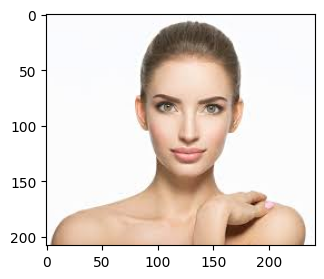

I0000 00:00:1713356618.051316   47884 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1713356618.106621   48044 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.54.03), renderer: NVIDIA A800-SXM4-80GB/PCIe/SSE2
W0000 00:00:1713356618.107844   47884 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


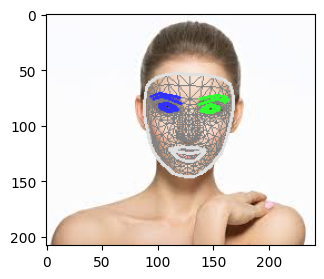

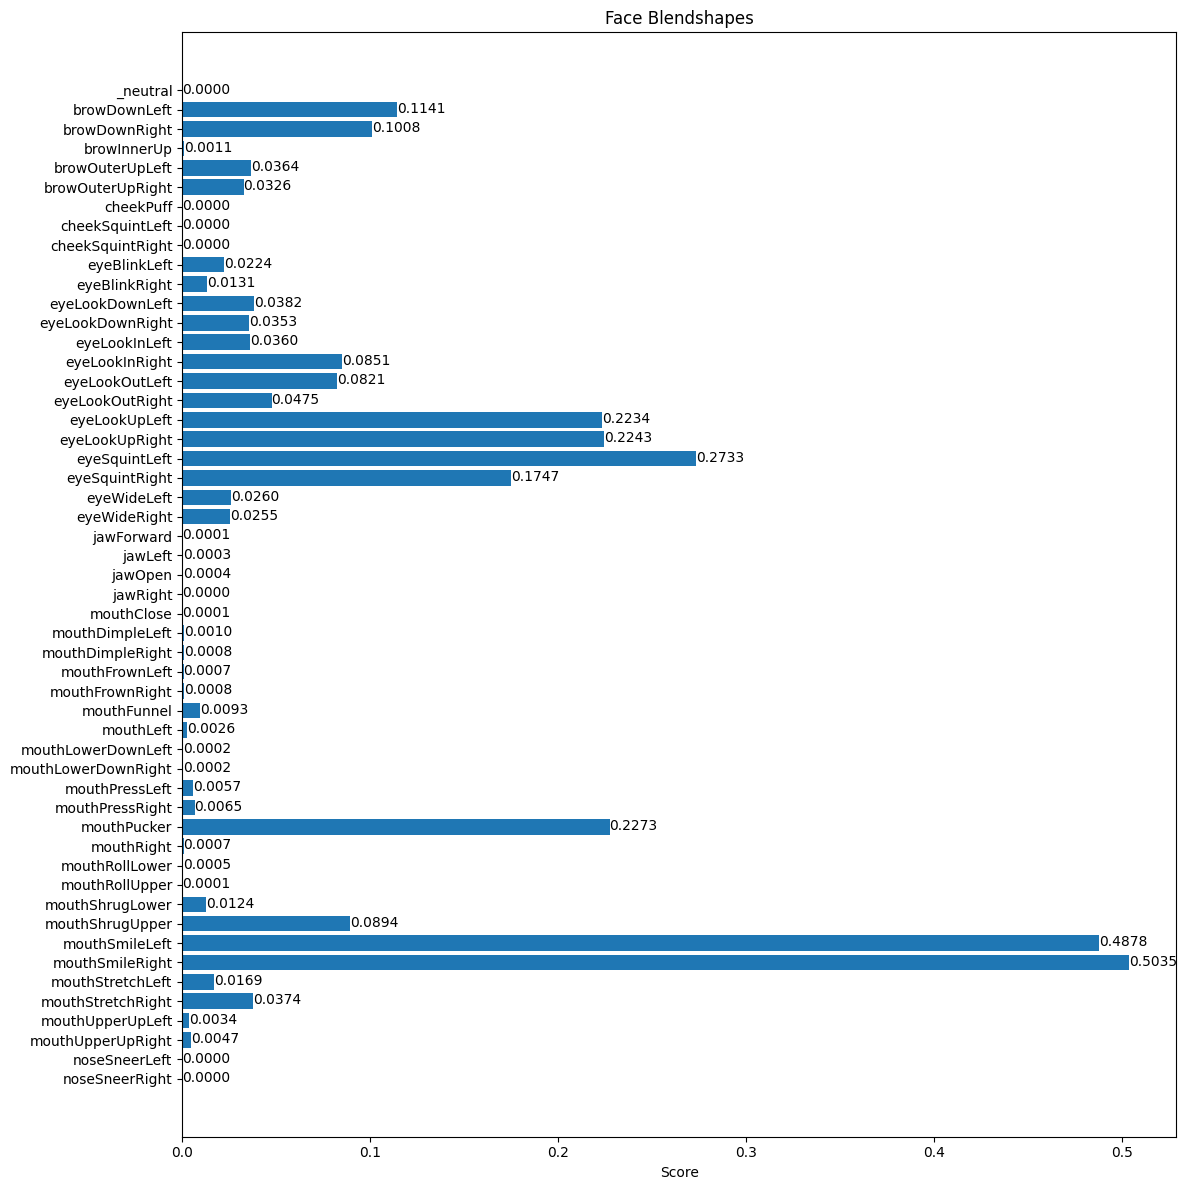

[array([[ 9.99521017e-01,  2.75361184e-02, -1.41435983e-02,
         1.30675066e+00],
       [-3.05349268e-02,  9.52110171e-01, -3.04227829e-01,
         1.65463912e+00],
       [ 5.08900173e-03,  3.04513752e-01,  9.52494860e-01,
        -3.26104889e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])]


In [2]:
import cv2
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe_util import *

model_path = './data/face_landmarker.task'

img_path = "/data/agent_h/Unknown.jpeg"
img = cv2.imread(img_path)
show_img_np(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

# STEP 2: Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path=model_path)
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

image = mp.Image.create_from_file(img_path)
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
show_img_np(annotated_image)

plot_face_blendshapes_bar_graph(detection_result.face_blendshapes[0])
print(detection_result.facial_transformation_matrixes)

## mediapipe landmark det on video

In [ ]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path=model_path)
VisionRunningMode = mp.tasks.vision.RunningMode
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1,
                                       running_mode=VisionRunningMode.VIDEO
                                      )
detector = vision.FaceLandmarker.create_from_options(options)

# STEP 3: Load the input image.
# image = mp.Image.create_from_file(img_path)
video_path  = all_video_paths[0]
cap = cv2.VideoCapture(video_path)

# Initialize RetinaFace, copy model from /data/small_modesl/retinaface.h5 to /home/agent_h/.deepface/weights/retinaface.h5
# Initialize a list to store the face landmarks
face_landmarks_list = []

# Loop through each frame of the video
while cap.isOpened():
    ret, frame = cap.read()

    # STEP 4: Detect face landmarks from the input image.
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
    # detection_result = detector.detect(mp_image)
    frame_timestamp_ms = cap.get(cv2.CAP_PROP_POS_MSEC)
    print(frame_timestamp_ms)
    detection_result = detector.detect_for_video(mp_image, int(frame_timestamp_ms))


    # STEP 5: Process the detection result. In this case, visualize it.
    annotated_image = draw_landmarks_on_image(mp_image.numpy_view(), detection_result)
    show_img_np(annotated_image)

## optimized

In [ ]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from tqdm import tqdm
from glob import glob
import os
from os.path import join, basename
import json
import pickle  


all_video_paths = glob("/data/agent_h/datasets_chunyu/clip_videos_v3/**/*.mp4", recursive=True)
print(len(all_video_paths))


def video_face_landmark_worker(video_path):
    output_root = "/data/agent_h/vsr_landmark_result_v3/"
    os.makedirs(output_root,exist_ok=True)
    
    base_options = python.BaseOptions(model_asset_path=model_path)
    VisionRunningMode = mp.tasks.vision.RunningMode
    options = vision.FaceLandmarkerOptions(base_options=base_options,
                                           output_face_blendshapes=True,
                                           output_facial_transformation_matrixes=True,
                                           num_faces=1,
                                           running_mode=VisionRunningMode.VIDEO
                                          )
    detector = vision.FaceLandmarker.create_from_options(options)
    cap = cv2.VideoCapture(video_path)
    face_landmarks_list = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
        frame_timestamp_ms = cap.get(cv2.CAP_PROP_POS_MSEC)
        detection_result = detector.detect_for_video(mp_image, int(frame_timestamp_ms))
        face_landmarks_list.append(detection_result)
    save_path = join(output_root,basename(video_path)[:-4]+"_landmarks.FaceLandmarkerResultList")
  
    with open(save_path, 'wb') as fp:
        pickle.dump(face_landmarks_list,fp)  
    fp.close()


# sp
# for video_path in tqdm(all_video_paths[:100]):
#     video_face_landmark_worker(video_path)


# mp

from multiprocessing import Pool
pool = Pool(32)
for _ in tqdm(pool.imap_unordered(video_face_landmark_worker, all_video_paths[:100]),
              total=len(all_video_paths[:100])):
    pass

        
# debug

# annotated_image = draw_landmarks_on_image(mp_image.numpy_view(), detection_result)
# show_img_np(annotated_image)

In [22]:
# load result
import pickle
import gzip

  
with gzip.open('/data/agent_h/vsr_landmark_result_v3/2020-01-09_3_landmarks.FaceLandmarkerResultListzip', 'rb') as f:
    result = pickle.load(f)  
print(result[0])

FaceLandmarkerResult(face_landmarks=[[NormalizedLandmark(x=0.7075035572052002, y=0.3222132623195648, z=-0.010706146247684956, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.7012761831283569, y=0.3044482171535492, z=-0.023196876049041748, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.7068895697593689, y=0.3106437027454376, z=-0.011791040189564228, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.7016710638999939, y=0.2829795479774475, z=-0.01628487929701805, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.700955331325531, y=0.29798611998558044, z=-0.025095464661717415, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.7025497555732727, y=0.2895704507827759, z=-0.02374367229640484, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.7085937261581421, y=0.2688041627407074, z=-0.013742044568061829, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.687155544757843, y=0.2621975541114807, z=0.02120247855782509, visibility=0.0, presence=0.0), NormalizedLandm

## shitty retinaface

In [7]:
import cv2
from retinaface import RetinaFace
import json
from pprint import pprint
import numpy as np


video_path = all_video_paths[0]
print(video_path)
# Load the sample video
cap = cv2.VideoCapture(video_path)

# Initialize RetinaFace, copy model from /data/small_modesl/retinaface.h5 to /home/agent_h/.deepface/weights/retinaface.h5
# Initialize a list to store the face landmarks
face_landmarks_list = []

# Loop through each frame of the video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Perform face detection and landmark detection using RetinaFace
    landmarks = RetinaFace.detect_faces(frame)
    h,w = frame.shape[:2]
    for face_id, face_landmark in landmarks.items():
        landmarks[face_id]['score'] = landmarks[face_id]['score'].item()
        landmarks[face_id]['facial_area'] = [landmarks[face_id]['facial_area'][0].item()/w,
                                             landmarks[face_id]['facial_area'][1].item()/h,
                                             landmarks[face_id]['facial_area'][2].item()/w,
                                             landmarks[face_id]['facial_area'][3].item()/h
                                            ]
        # 
        landmarks[face_id]['landmarks'] = []
        

                                             
    face_landmarks_list.append(landmarks)
    

pprint(face_landmarks_list[0])

# Release the video capture
cap.release()

# Convert NumPy objects to Python int/float
def convert_numpy(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    return obj

# Serialize the JSON structure

# Save the face landmarks as a list of JSON
output_path = "/data/agent_h/sample_result.json"
face_landmarks_list = json.dumps(face_landmarks_list, default=convert_numpy)
with open(output_path, "w") as f:
    json.dump(face_landmarks_list, f)
    


/data/agent_h/datasets_chunyu/clip_videos_v3/2020-01-09/2020-01-09_3.mp4
{'face_1': {'facial_area': [325, 66, 378, 138],
            'landmarks': {'left_eye': [354.70422, 96.61805],
                          'mouth_left': [351.98804, 120.61711],
                          'mouth_right': [332.97263, 119.24986],
                          'nose': [336.25638, 107.76537],
                          'right_eye': [332.38998, 94.78933]},
            'score': 0.9990843534469604}}


ValueError: Circular reference detected